# MNIST Digits - Classification Using SVM

In this notebook, we'll explore the popular MNIST dataset and build an SVM model to classify handwritten digits. <a href='http://yann.lecun.com/exdb/mnist/'>Here is a detailed description of the dataset.</a>

We'll divide the analysis into the following parts:
- Data understanding and cleaning
- Data preparation for model building
- Building an SVM model - hyperparameter tuning, model evaluation etc.


## Data Understanding and Cleaning
 
 Let's understand the dataset and see if it needs some cleaning etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import gc

In [2]:
# read the dataset
digits = pd.read_csv(r"C:\Users\SP186092\Downloads\Handwritten_digit_recognition\digit-recognizer\train.csv")
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
four = digits.iloc[3, 1:]
four.shape

(784,)

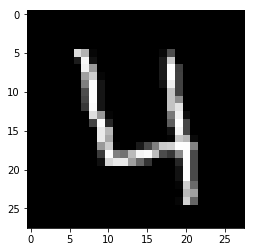

In [5]:
four = four.values.reshape(28, 28)
plt.imshow(four, cmap='gray')

#### Side note: Indexing Recall ####
`list =    [0, 4, 2, 10, 22, 101, 10]` <br>
`indices = [0, 1, 2, 3, ...,        ]` <br>
`reverse = [-n           -3  -2   -1]` <br>

In [6]:
# visualise the array
print(four[5:-5, 5:-5])

[[  0 220 179   6   0   0   0   0   0   0   0   0   9  77   0   0   0   0]
 [  0  28 247  17   0   0   0   0   0   0   0   0  27 202   0   0   0   0]
 [  0   0 242 155   0   0   0   0   0   0   0   0  27 254  63   0   0   0]
 [  0   0 160 207   6   0   0   0   0   0   0   0  27 254  65   0   0   0]
 [  0   0 127 254  21   0   0   0   0   0   0   0  20 239  65   0   0   0]
 [  0   0  77 254  21   0   0   0   0   0   0   0   0 195  65   0   0   0]
 [  0   0  70 254  21   0   0   0   0   0   0   0   0 195 142   0   0   0]
 [  0   0  56 251  21   0   0   0   0   0   0   0   0 195 227   0   0   0]
 [  0   0   0 222 153   5   0   0   0   0   0   0   0 120 240  13   0   0]
 [  0   0   0  67 251  40   0   0   0   0   0   0   0  94 255  69   0   0]
 [  0   0   0   0 234 184   0   0   0   0   0   0   0  19 245  69   0   0]
 [  0   0   0   0 234 169   0   0   0   0   0   0   0   3 199 182  10   0]
 [  0   0   0   0 154 205   4   0   0  26  72 128 203 208 254 254 131   0]
 [  0   0   0   0  61 254

In [7]:
# Summarise the counts of 'label' to see how many labels of each digit are present
digits.label.astype('category').value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [8]:
# Summarise count in terms of percentage 
100*(round(digits.label.astype('category').value_counts()/len(digits.index), 4))

1    11.15
7    10.48
3    10.36
9     9.97
2     9.95
6     9.85
0     9.84
4     9.70
8     9.67
5     9.04
Name: label, dtype: float64

Thus, each digit/label has an approximately 9%-11% fraction in the dataset and the **dataset is balanced**. This is an important factor in considering the choices of models to be used, especially SVM, since **SVMs rarely perform well on imbalanced data** (think about why that might be the case).

Let's quickly look at missing values, if any.

In [9]:
# missing values - there are none
digits.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
           ..
pixel754    0
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

Also, let's look at the average values of each column, since we'll need to do some rescaling in case the ranges vary too much.

In [10]:
# average values/distributions of features
description = digits.describe()
description

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


You can see that the max value of the mean and maximum values of some features (pixels) is 139, 255 etc., whereas most features lie in much lower ranges  (look at description of pixel 0, pixel 1 etc. above).

Thus, it seems like a good idea to rescale the features.

## Data Preparation for Model Building

Let's now prepare the dataset for building the model. We'll only use a fraction of the data else training will take a long time.


In [11]:
# Creating training and test sets
# Splitting the data into train and test
X = digits.iloc[:, 1:]
Y = digits.iloc[:, 0]

# Rescaling the features
from sklearn.preprocessing import scale
X = scale(X)

# train test split with train_size=10% and test size=90%
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.70, random_state=101)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  
C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(29399, 784)
(12601, 784)
(29399,)
(12601,)


In [12]:
# delete test set from memory, to avoid a memory error
# we'll anyway use CV to evaluate the model, and can use the separate test.csv file as well
# to evaluate the model finally

# del x_test
# del y_test

## Model Building

Let's now build the model and tune the hyperparameters. Let's start with a **linear model** first.

### Linear SVM

Let's first try building a linear SVM model (i.e. a linear kernel). 

In [13]:
from sklearn import svm
from sklearn import metrics

# an initial SVM model with linear kernel   
svm_linear = svm.SVC(kernel='linear')

# fit
svm_linear.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
# predict
predictions = svm_linear.predict(x_test)
predictions[:10]

array([1, 3, 0, 0, 1, 9, 1, 5, 0, 6], dtype=int64)

In [15]:
# evaluation: accuracy
# C(i, j) represents the number of points known to be in class i 
# but predicted to be in class j
confusion = metrics.confusion_matrix(y_true = y_test, y_pred = predictions)
confusion

array([[1180,    0,    3,    3,    2,    9,   10,    1,    5,    0],
       [   0, 1397,    9,    3,    2,    1,    1,    2,    6,    1],
       [  12,   23, 1138,   26,   12,    6,   10,   11,   18,    2],
       [   7,    8,   47, 1141,    5,   42,    1,    6,   18,    9],
       [   6,    3,    6,    1, 1146,    3,    5,    3,    2,   34],
       [  14,    3,   14,   73,   14,  955,   10,    3,   27,    8],
       [   9,    3,   18,    0,    7,   18, 1182,    0,    5,    0],
       [   2,    5,   12,   10,   25,    1,    0, 1223,    0,   37],
       [  14,   14,   27,   45,    7,   40,    7,    7, 1056,   11],
       [   7,    6,    7,   12,   62,    5,    1,   55,   15, 1139]],
      dtype=int64)

In [16]:
# measure accuracy
metrics.accuracy_score(y_true=y_test, y_pred=predictions)

0.9171494325847155

In [17]:
# class-wise accuracy
class_wise = metrics.classification_report(y_true=y_test, y_pred=predictions)
print(class_wise)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1213
           1       0.96      0.98      0.97      1422
           2       0.89      0.90      0.90      1258
           3       0.87      0.89      0.88      1284
           4       0.89      0.95      0.92      1209
           5       0.88      0.85      0.87      1121
           6       0.96      0.95      0.96      1242
           7       0.93      0.93      0.93      1315
           8       0.92      0.86      0.89      1228
           9       0.92      0.87      0.89      1309

   micro avg       0.92      0.92      0.92     12601
   macro avg       0.92      0.92      0.92     12601
weighted avg       0.92      0.92      0.92     12601



In [18]:
# run gc.collect() (garbage collect) to free up memory
# else, since the dataset is large and SVM is computationally heavy,
# it'll throw a memory error while training
gc.collect()

28

### Non-Linear SVM

Let's now try a non-linear model with the RBF kernel.

In [19]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(x_train, y_train)

C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [27]:
# predict
predictions = svm_rbf.predict(x_test)

# accuracy 
print(metrics.accuracy_score(y_true=y_test, y_pred=predictions))

KeyboardInterrupt: 

The accuracy achieved with a non-linear kernel is slightly higher than a linear one. Let's now do a grid search CV to tune the hyperparameters C and gamma.

### Grid Search Cross-Validation

In [21]:
# conduct (grid search) cross-validation to find the optimal values 
# of cost C and the choice of kernel

from sklearn.model_selection import GridSearchCV

parameters = {'C':[1, 10, 100], 
             'gamma': [1e-2, 1e-3, 1e-4]}

# instantiate a model 
svc_grid_search = svm.SVC(kernel="rbf")

# create a classifier to perform grid search
clf = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')

# fit
clf.fit(x_train, y_train)

C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [22]:
# results
cv_results = pd.DataFrame(clf.cv_results_)
cv_results

C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,758.521132,353.467364,186.197526,93.783935,1,0.01,"{'C': 1, 'gamma': 0.01}",0.809752,0.803347,0.801776,0.804959,0.003450,9,0.999643,0.999898,0.999694,0.999745,0.000110
1,83.152678,1.236056,55.133277,0.246124,1,0.001,"{'C': 1, 'gamma': 0.001}",0.953586,0.948464,0.946514,0.949522,0.002982,3,0.975250,0.976837,0.975972,0.976020,0.000649
2,117.835695,0.474489,77.814851,0.196924,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.924615,0.919584,0.919159,0.921120,0.002478,6,0.928965,0.930714,0.930670,0.930117,0.000814
3,481.427462,1.089683,115.222608,0.262364,10,0.01,"{'C': 10, 'gamma': 0.01}",0.823727,0.816002,0.817801,0.819178,0.003301,7,1.000000,1.000000,1.000000,1.000000,0.000000
4,70.398296,0.537616,48.820156,0.294045,10,0.001,"{'C': 10, 'gamma': 0.001}",0.963175,0.957343,0.956824,0.959114,0.002880,1,0.998112,0.998776,0.998776,0.998554,0.000313
5,55.693815,0.129384,47.463381,0.383539,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.944099,0.940198,0.936613,0.940304,0.003057,5,0.958257,0.961378,0.963065,0.960900,0.001992
6,755.812760,380.169624,183.816179,95.698380,100,0.01,"{'C': 100, 'gamma': 0.01}",0.823727,0.816002,0.817801,0.819178,0.003301,7,1.000000,1.000000,1.000000,1.000000,0.000000
7,69.992022,0.504907,48.911886,0.271682,100,0.001,"{'C': 100, 'gamma': 0.001}",0.962562,0.955506,0.956824,0.958298,0.003064,2,1.000000,1.000000,1.000000,1.000000,0.000000
8,41.370768,0.199295,37.166689,0.189027,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.947975,0.945709,0.941513,0.945066,0.002677,4,0.988314,0.988980,0.988011,0.988435,0.000404


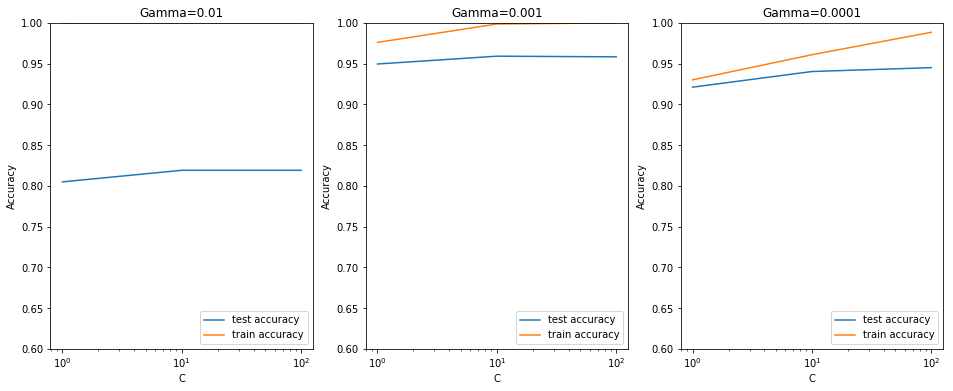

In [23]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='lower right')
plt.xscale('log')

plt.show()

From the plot above, we can observe that (from higher to lower gamma / left to right):
- At very high gamma (0.01), the model is achieving 100% accuracy on the training data, though the test score is quite low (<75%). Thus, the model is overfitting.

- At gamma=0.001, the training and test scores are comparable at around C=1, though the model starts to overfit at higher values of C

- At gamma=0.0001, the model does not overfit till C=10 but starts showing signs at C=100. Also, the training and test scores are slightly lower than at gamma=0.001.

Thus, it seems that the best combination is gamma=0.001 and C=1 (the plot in the middle), which gives the highest test accuracy (~92%) while avoiding overfitting.

Let's now build the final model and see the performance on test data.

### Final Model

Let's now build the final model with chosen hyperparameters.

In [24]:
# optimal hyperparameters
best_C = 1
best_gamma = 0.001

# model
svm_final = svm.SVC(kernel='rbf', C=best_C, gamma=best_gamma)

# fit
svm_final.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
# predict
predictions = svm_final.predict(x_test)

In [26]:
# evaluation: CM 
confusion = metrics.confusion_matrix(y_true = y_test, y_pred = predictions)

# measure accuracy
test_accuracy = metrics.accuracy_score(y_true=y_test, y_pred=predictions)

print(test_accuracy, "\n")
print(confusion)


0.95746369335767 

[[1193    0    3    0    2    2    5    2    5    1]
 [   0 1394    8    4    4    1    1    5    4    1]
 [   4    4 1208    6    9    1    4   12    7    3]
 [   2    4   19 1208    4   14    0   13   11    9]
 [   3    1    8    0 1170    2    2    5    3   15]
 [   3    2    2   21    6 1059   13    8    5    2]
 [   7    2    7    1    5   11 1201    6    2    0]
 [   1    2    9    6   13    2    0 1264    1   17]
 [   2    5    8    8    9   11    7    8 1164    6]
 [   4    6    3   13   29    2    0   39    9 1204]]


In [28]:
test = pd.read_csv(r"C:\Users\SP186092\Downloads\Handwritten_digit_recognition\digit-recognizer\test.csv")
test_scaled = scale(test)
test.head()

C:\Users\SP186092\AppData\Local\Continuum\python\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
pred_test = svm_final.predict(test_scaled)
pred_test

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

In [31]:
#exporting the predicted dataset to upload on Kaggle 
df = pd.DataFrame(pred_test) 
df.to_csv(r"C:\Users\SP186092\Downloads\Handwritten_digit_recognition\digit-recognizer\results.csv")

### Conclusion

The final accuracy on test data is approx. 95.7%.

